In [1]:
#%%
import numpy as np
import pandas as pd
from sympy import im 
import torch 
import torch.nn 
import matplotlib.pyplot as plt
import warnings
from pd.nn.model import MLP

from pd.metric import amex_metric
from pd.data.loader import CustomerData, DataLoader
from pd.params import *
from pd.pred import pred


In [7]:
train_data = pd.read_parquet(DATADIR+"train_data.parquet")
train_labels = pd.read_csv(DATADIR+"train_labels.csv")
train_labels.set_index("customer_ID", inplace=True)
cont_cols = [col for col in train_data.columns.to_list() if col not in CATCOLS + ["customer_ID", "S_2", "target"]]


In [8]:
train_customers = train_data.customer_ID
train_count =  train_customers.value_counts()
train_c13 = train_count[train_count==13].index

In [9]:
train_data = train_data[train_data.customer_ID.isin(train_c13)]

In [10]:
f13 = train_data.groupby("customer_ID")

In [11]:
test_data = pd.read_parquet(DATADIR+"test_data.parquet")
test_customers = test_data.customer_ID
test_count =  test_customers.value_counts()
test_c13 = test_count[test_count==13].index


In [12]:
ftest13 = test_data.groupby("customer_ID")

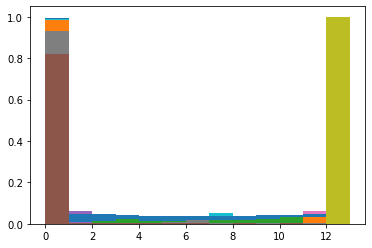

In [13]:
f13c = f13.count()
most_nan_cols = {}
for c in f13c.columns:
    _ = plt.hist(f13c[c], bins=13, range=[0, 13], density=True)
    if _[0][:2].sum()>0.5:
        most_nan_cols[c] = _



In [14]:
most_nan_cols.keys()

dict_keys(['D_42', 'D_50', 'D_53', 'D_73', 'D_76', 'B_29', 'D_88', 'D_110', 'B_39', 'B_42', 'D_132', 'D_134', 'D_142'])

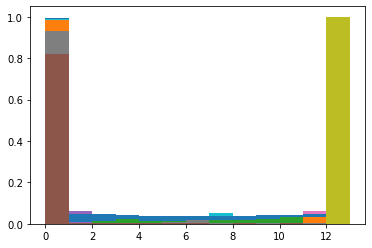

In [15]:
most_full_cols = {}
for c in f13c.columns:
    _ = plt.hist(f13c[c], bins=13, range=[0, 13], density=True)
    if _[0][-2:].sum()>0.8:
        most_full_cols[c] = _[0]


In [16]:
MostNaNCols = ['D_42', 'D_50', 'D_53', 'D_73', 'D_76', 'B_29', 'D_88', 'D_110', 'B_39', 'B_42', 'D_132', 'D_134', 'D_142']
my_cols = [col for col in cont_cols if col not in MostNaNCols]
d = np.zeros((len(set(train_c13)), 13, len(my_cols)))

train_labels_array = np.zeros((len(set(train_c13)) ,1))
train_labels_dict = {}

for idx, c in enumerate(set(train_c13)):
    cd = f13.get_group(c)[my_cols].values
    d[idx, :, :] = cd
    
    label = train_labels.loc[c]
    train_labels_array[idx] = label
    train_labels_dict[idx] = c

np.save("c13.npy", d)

In [17]:
def get_c13_data(customer_ids, customer_data, cols, train_labels=None, test_mode=False):
    d = np.zeros((len(set(customer_ids)), 13, len(cols)))

    labels_array = np.zeros((len(set(customer_ids)) ,1))
    id_dict = {}

    for idx, c in enumerate(set(customer_ids)):
        cd = customer_data.get_group(c)[cols].values
        d[idx, :, :] = cd
        id_dict[idx] = c
        if not test_mode:
            label = train_labels.loc[c]
            labels_array[idx] = label
    d = np.nan_to_num(d)
    if test_mode:
        return d, (None, id_dict)
    else:
        return d, (labels_array, id_dict)

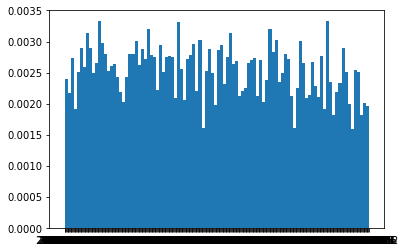

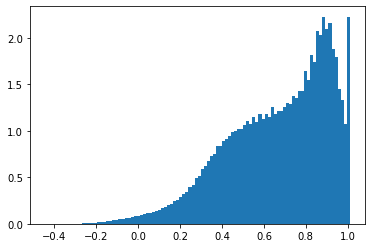

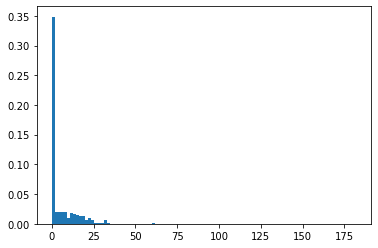

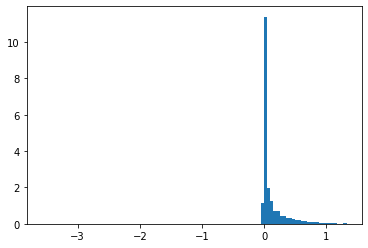

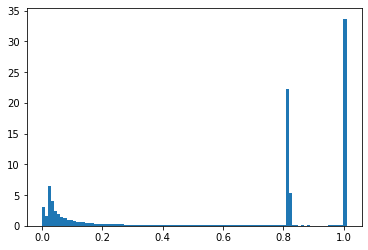

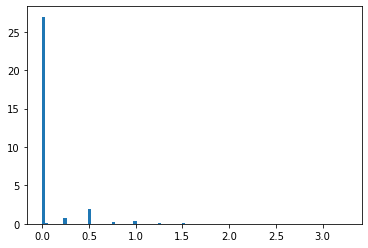

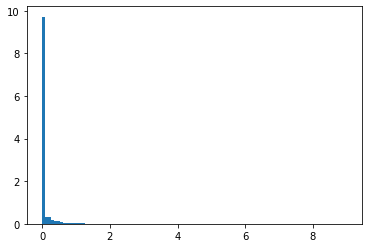

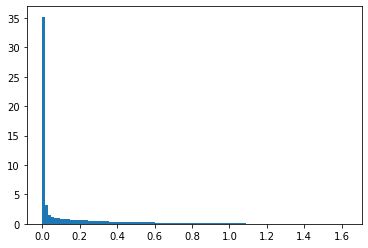

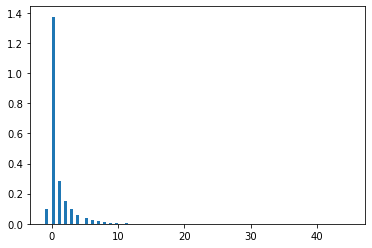

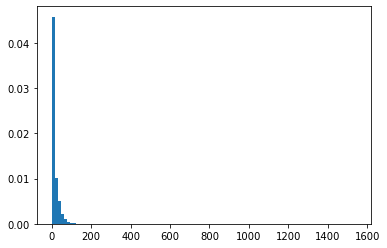

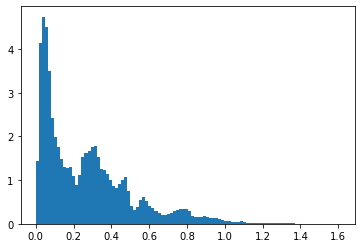

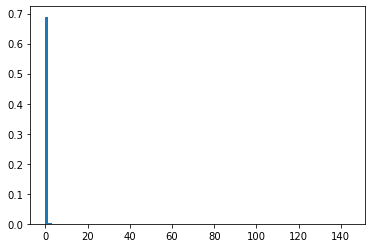

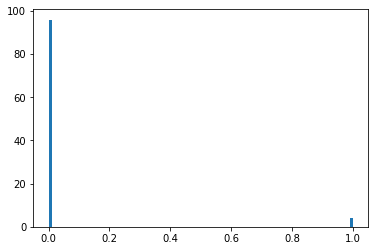

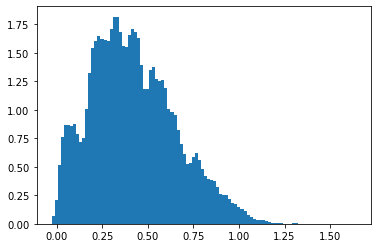

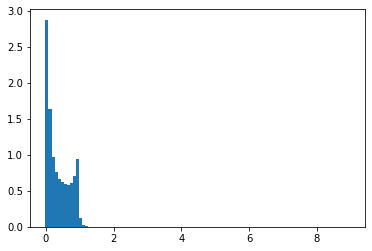

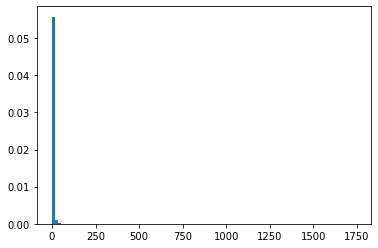

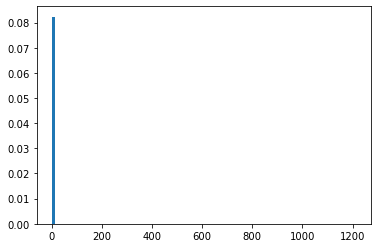

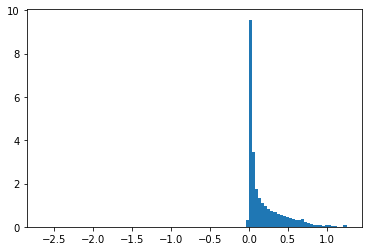

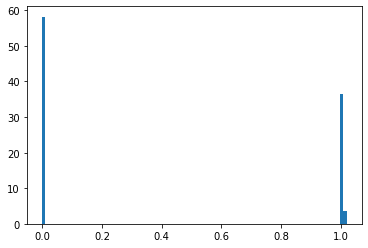

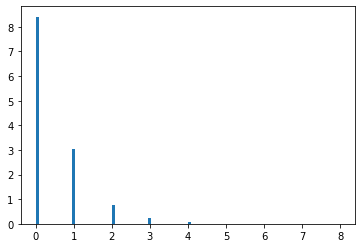

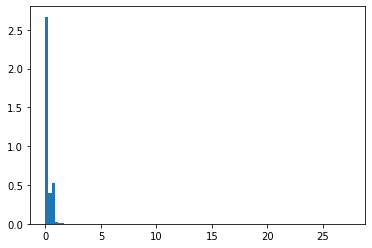

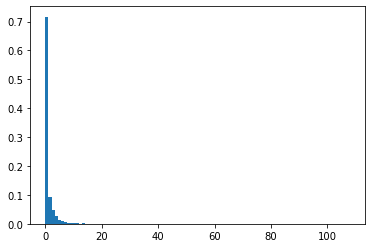

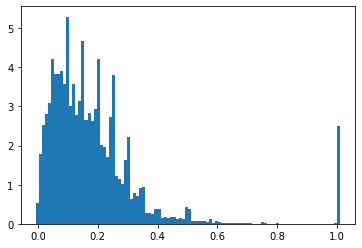

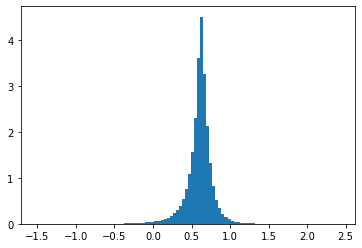

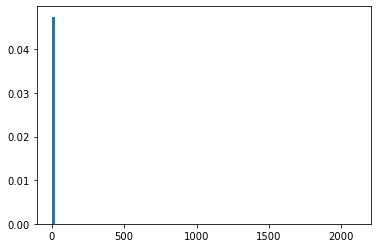

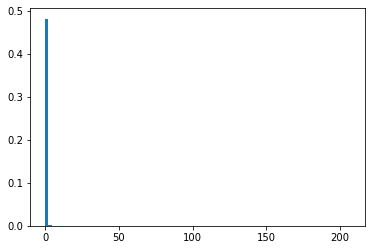

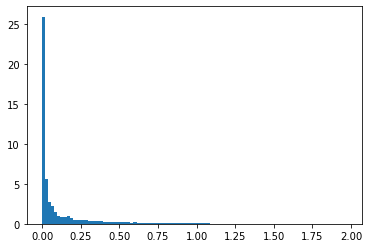

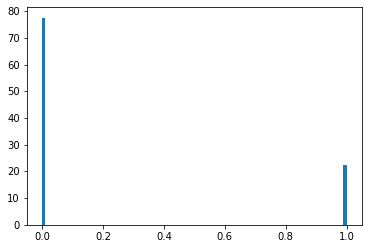

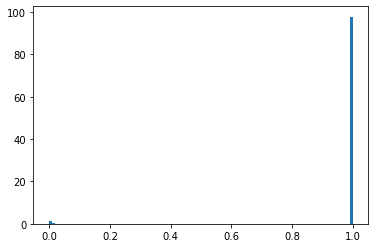

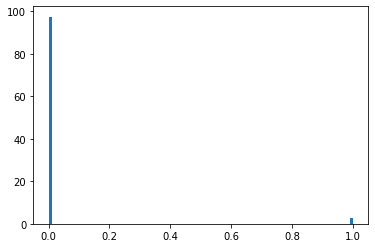

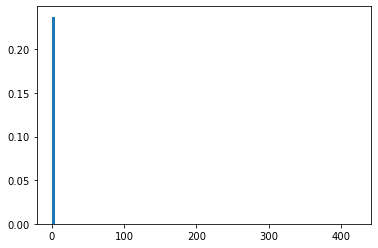

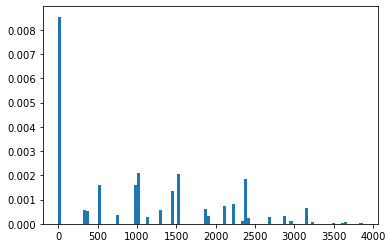

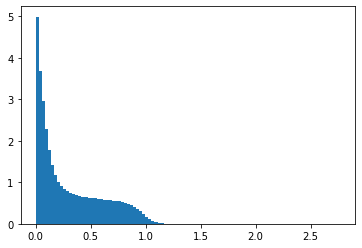

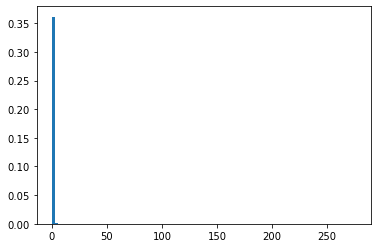

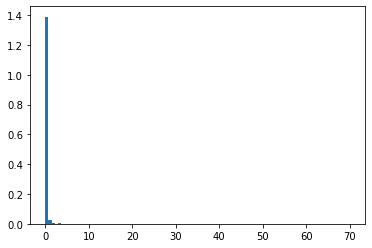

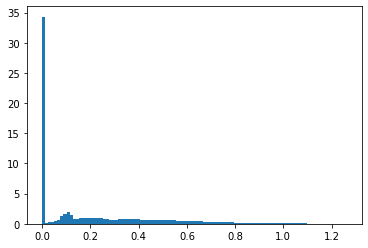

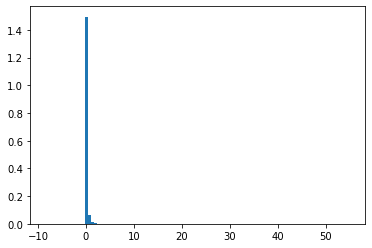

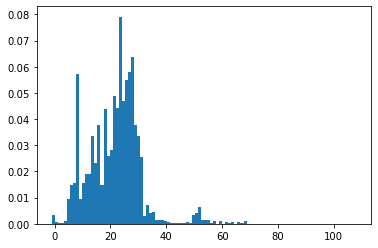

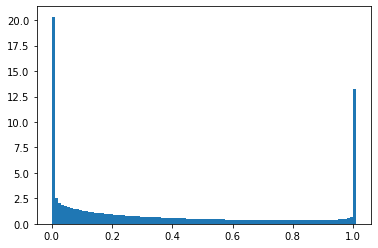

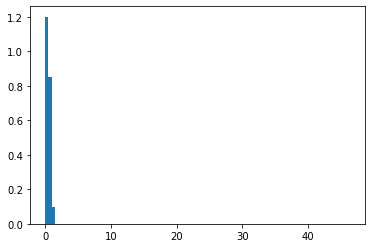

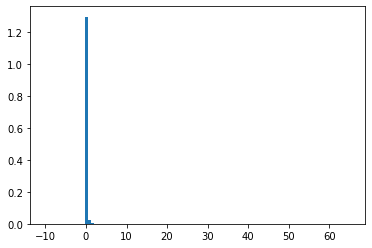

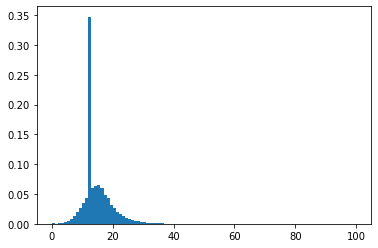

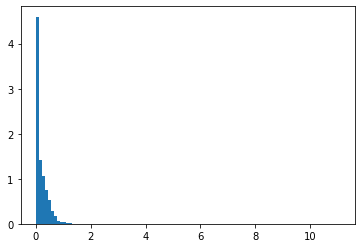

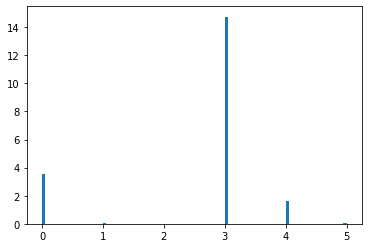

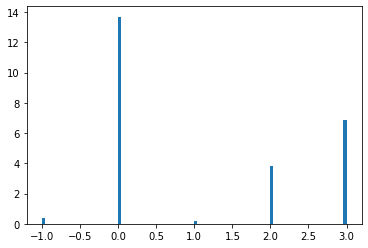

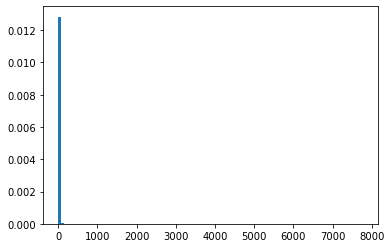

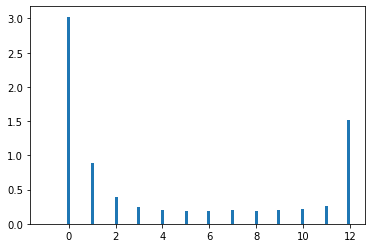

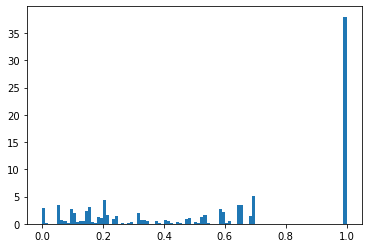

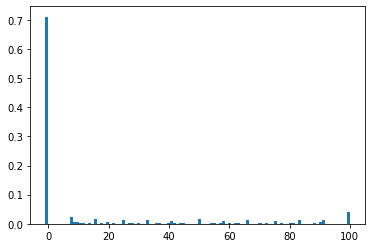

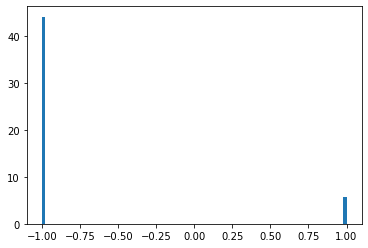

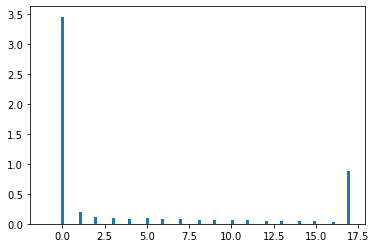

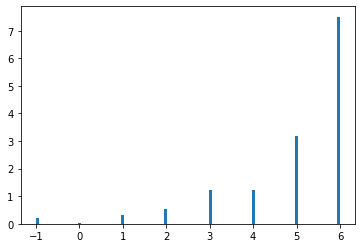

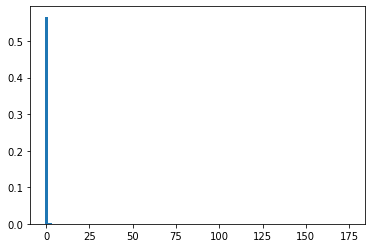

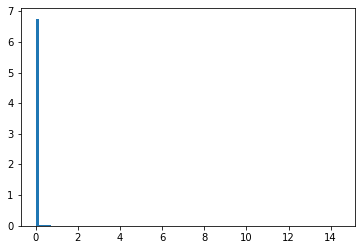

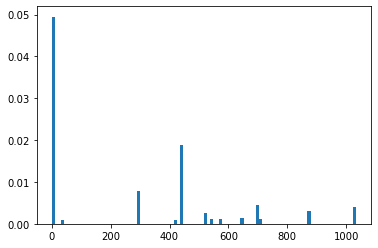

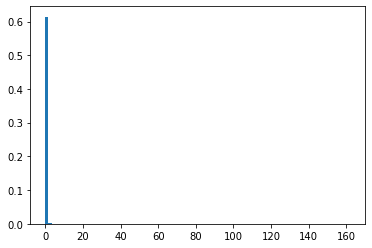

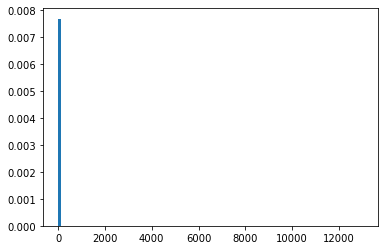

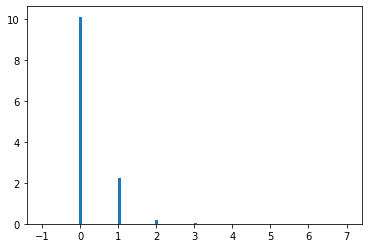

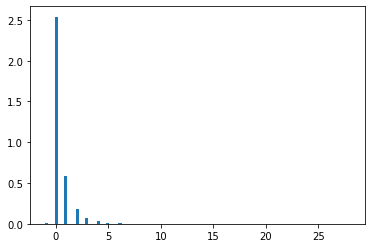

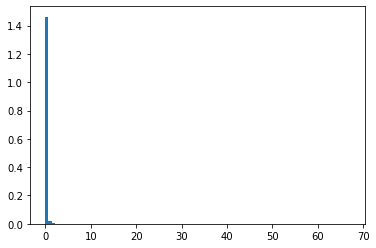

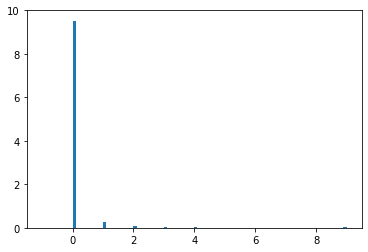

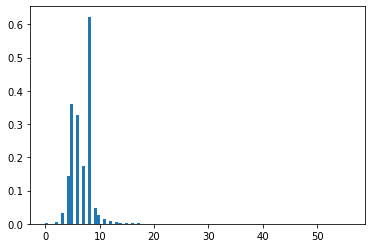

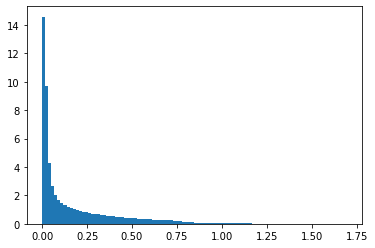

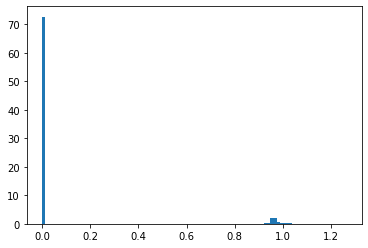

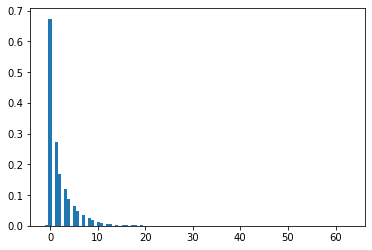

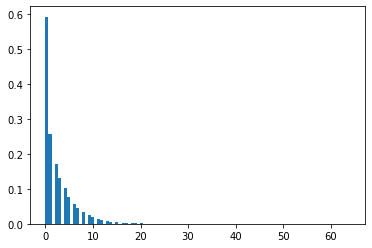

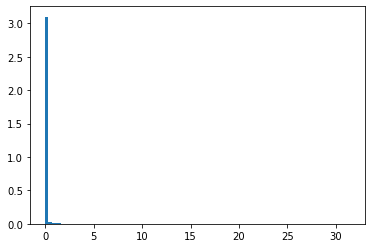

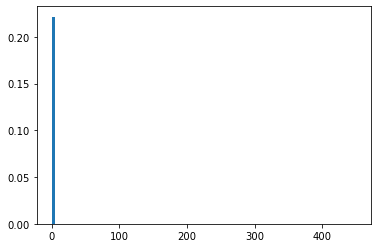

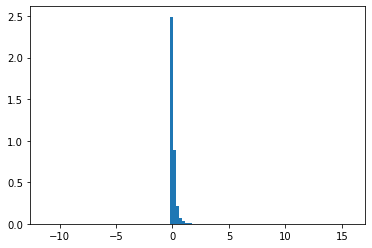

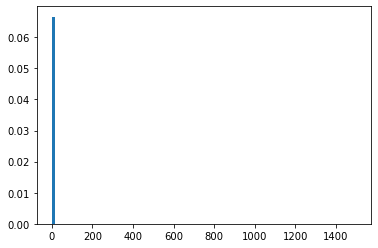

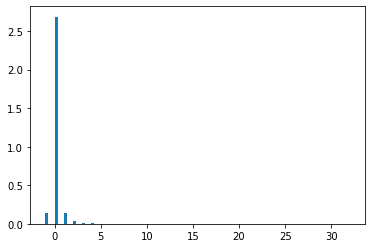

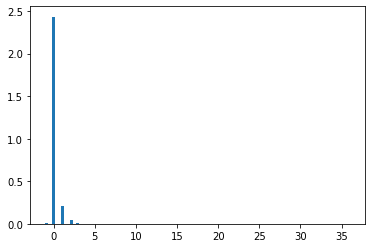

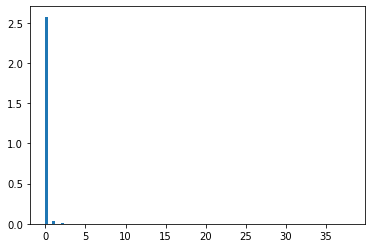

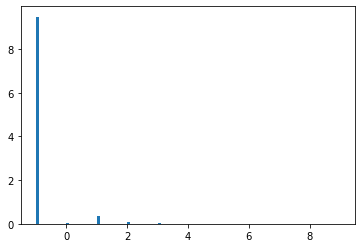

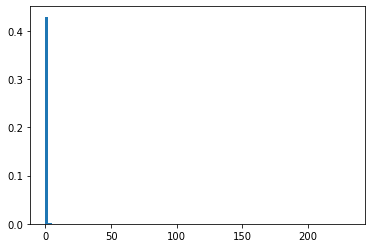

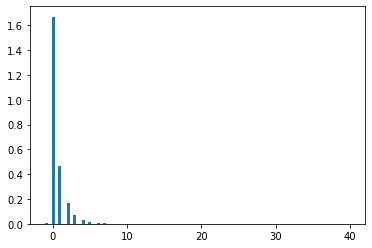

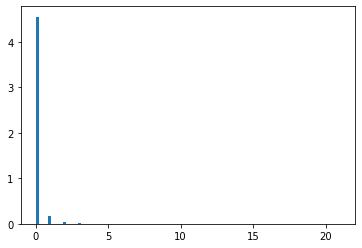

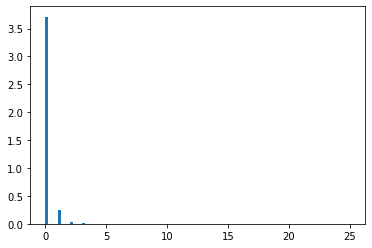

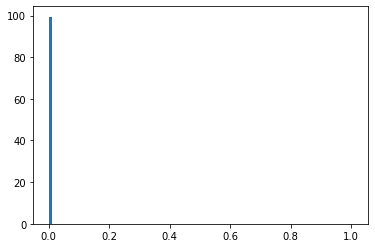

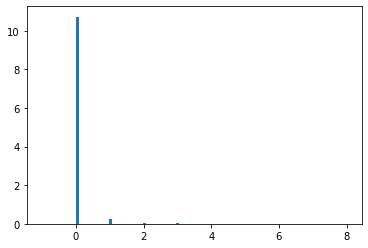

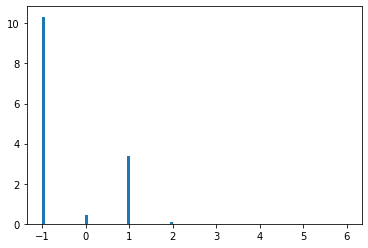

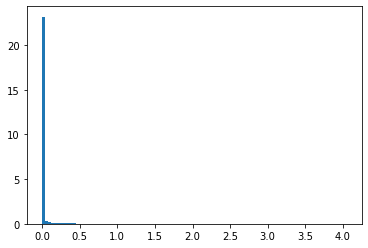

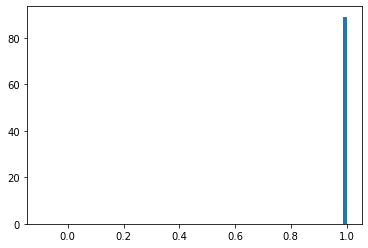

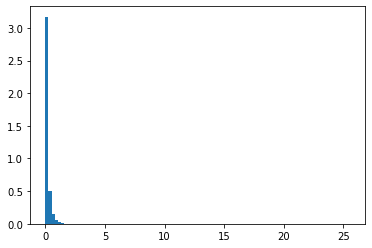

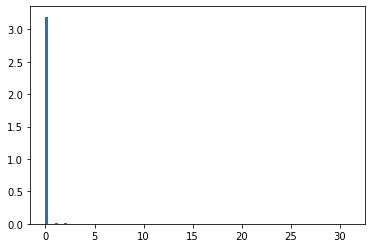

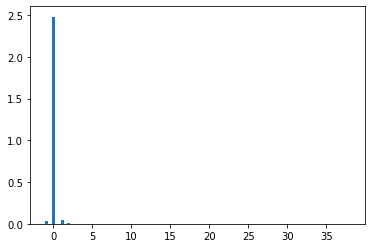

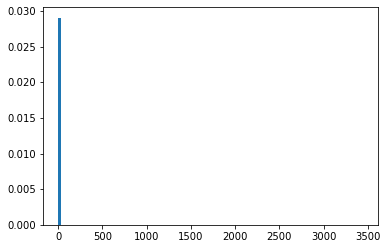

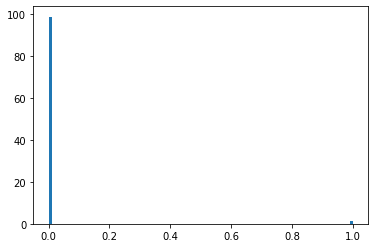

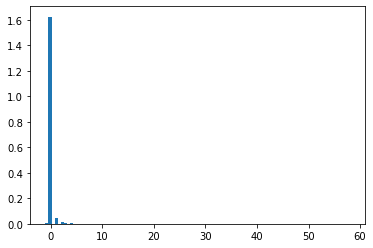

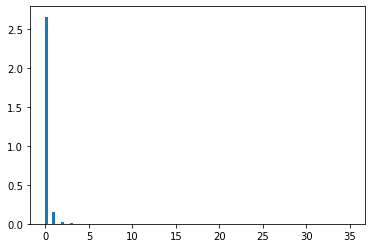

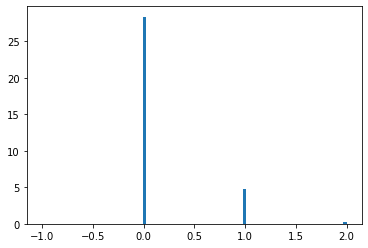

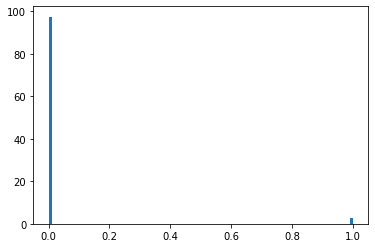

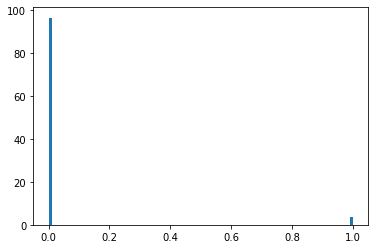

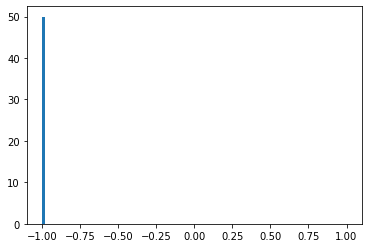

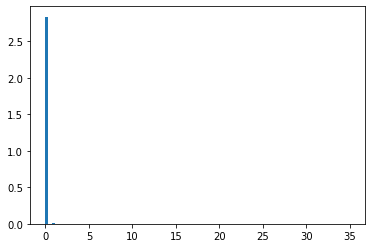

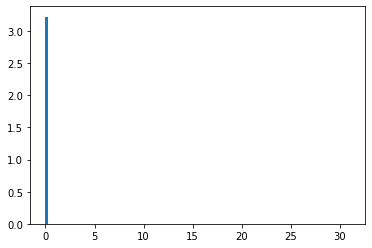

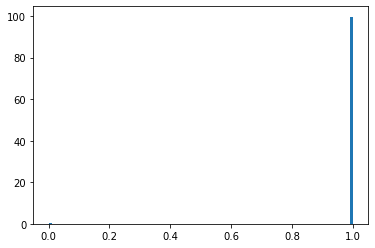

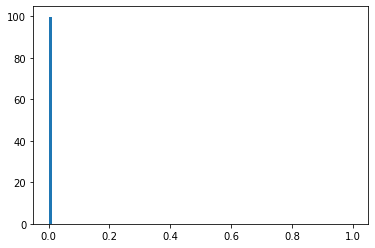

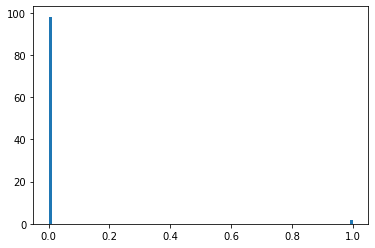

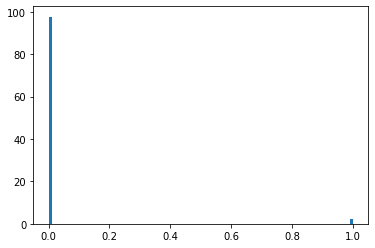

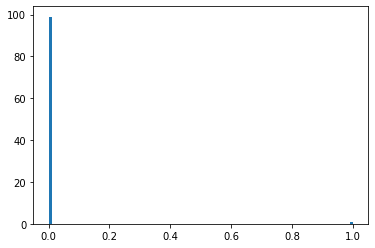

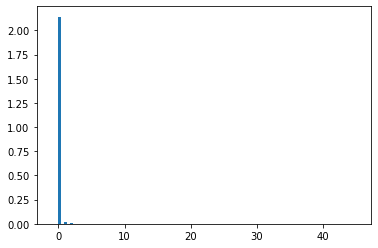

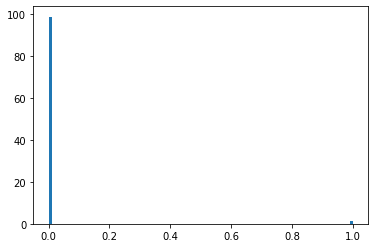

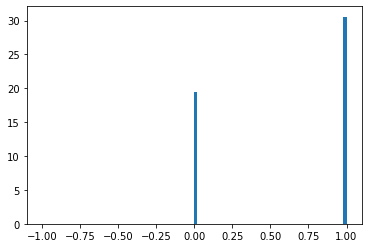

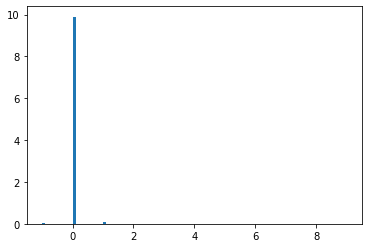

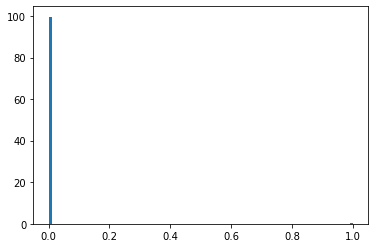

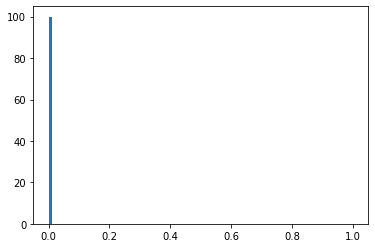

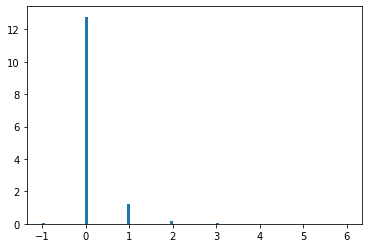

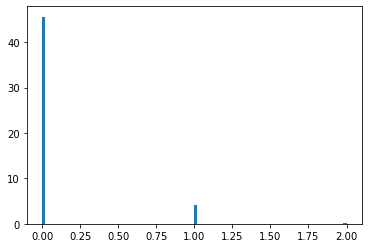

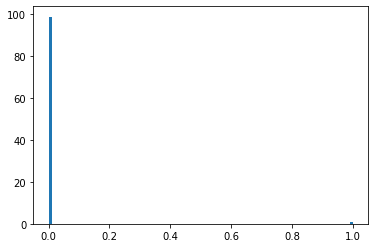

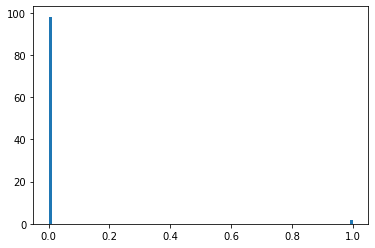

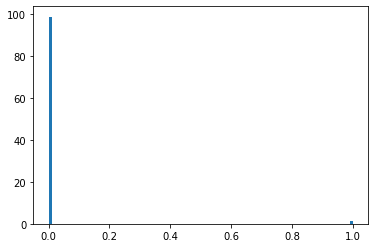

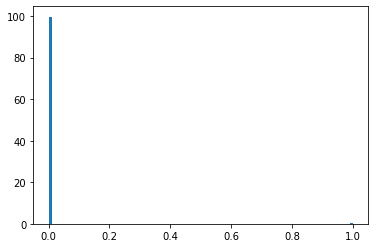

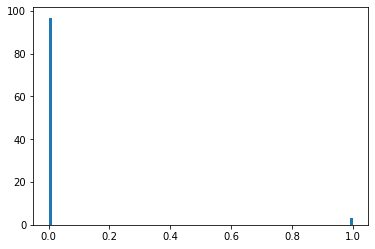

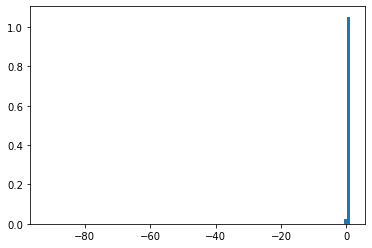

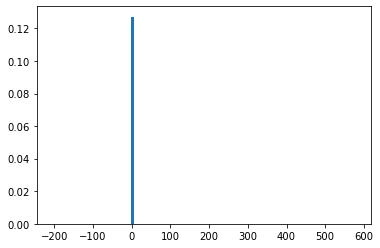

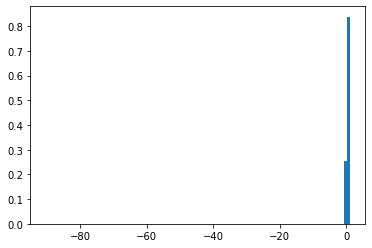

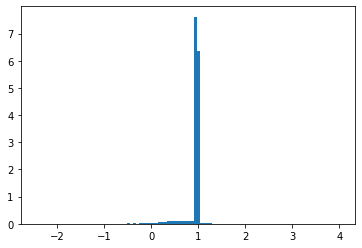

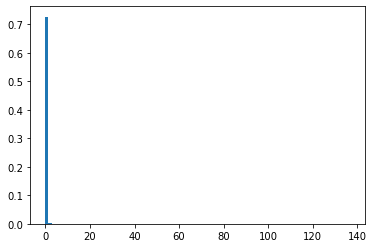

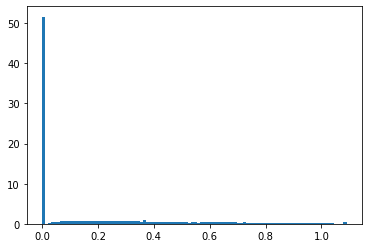

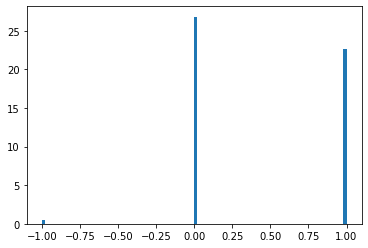

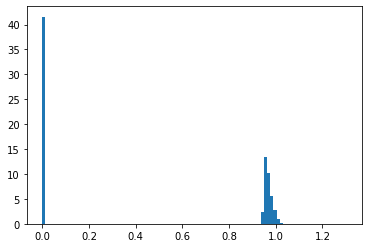

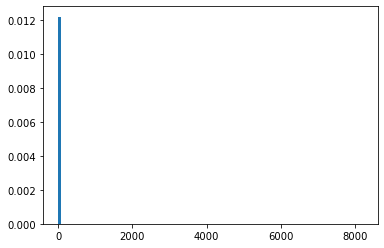

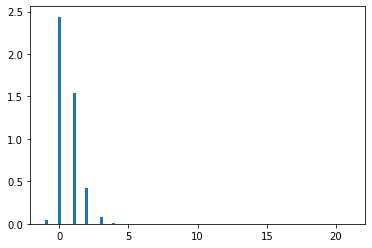

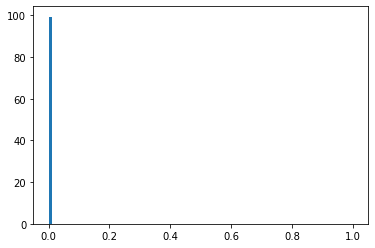

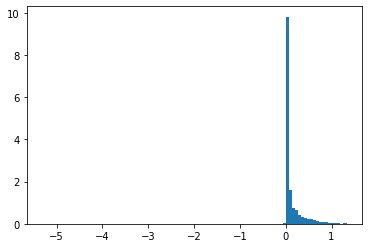

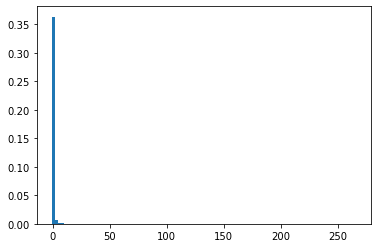

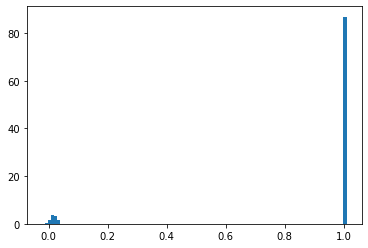

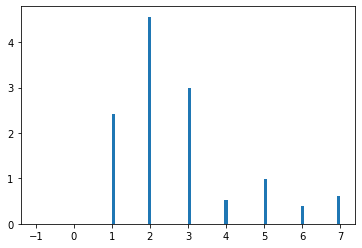

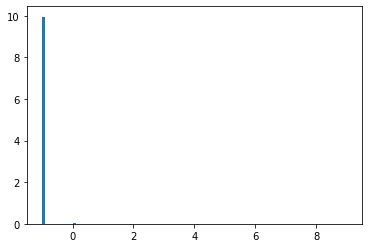

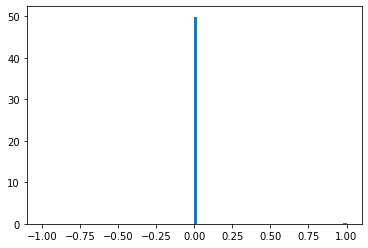

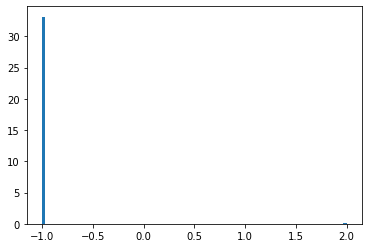

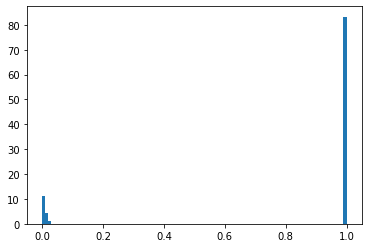

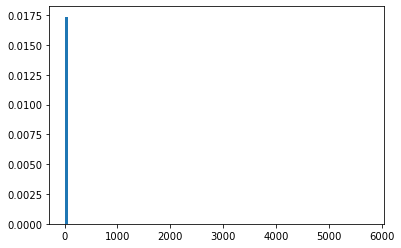

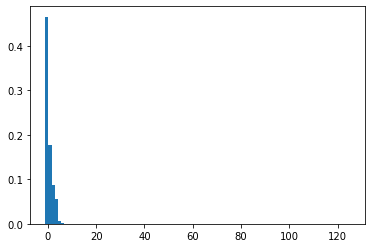

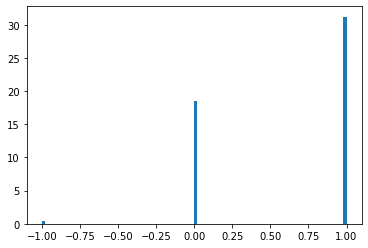

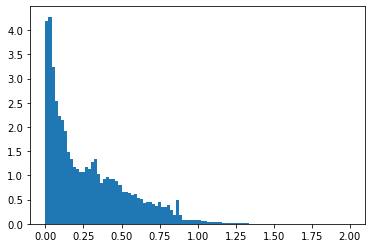

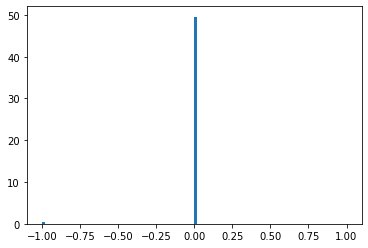

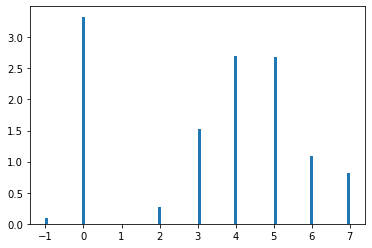

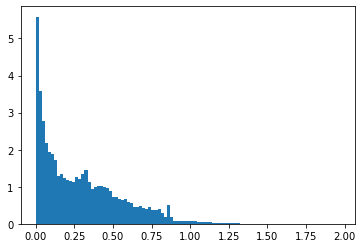

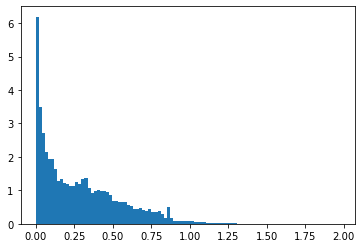

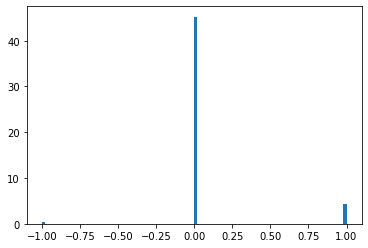

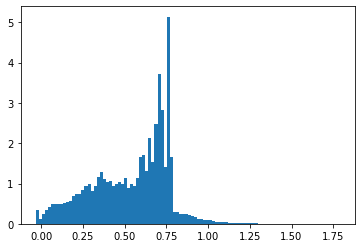

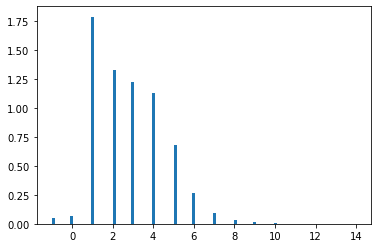

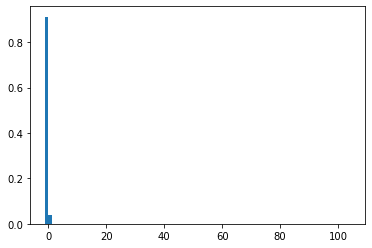

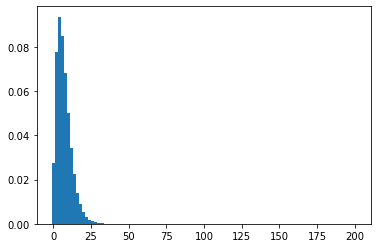

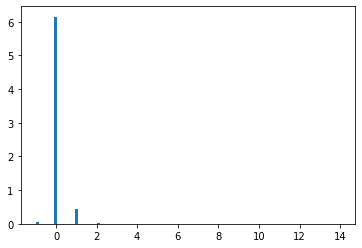

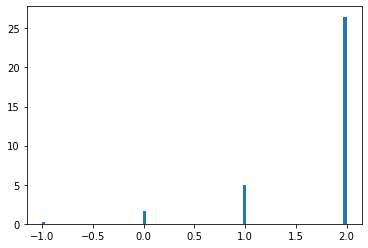

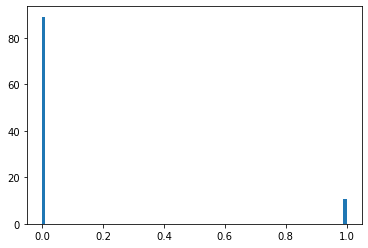

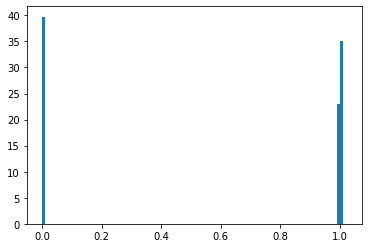

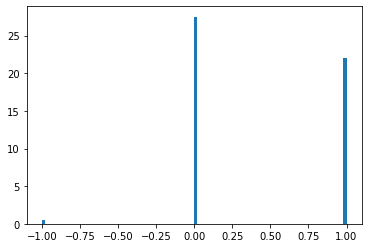

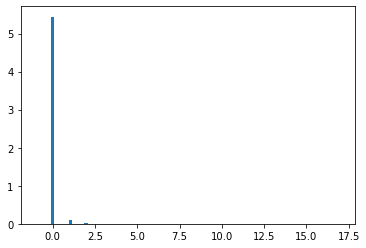

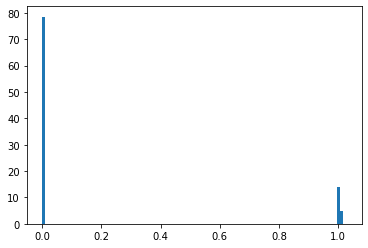

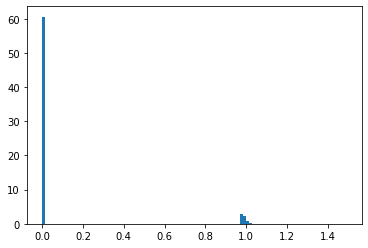

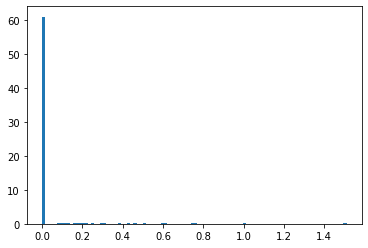

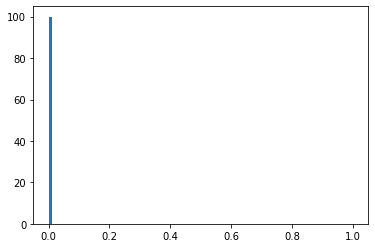

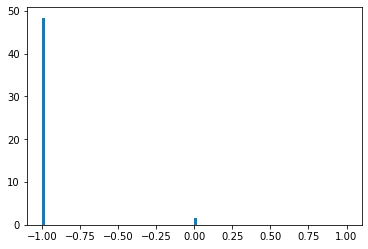

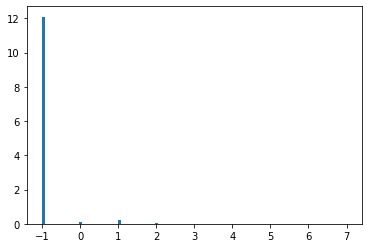

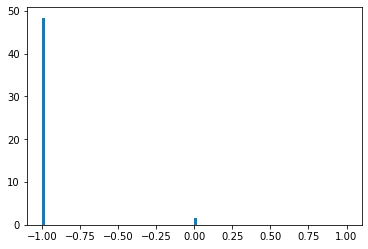

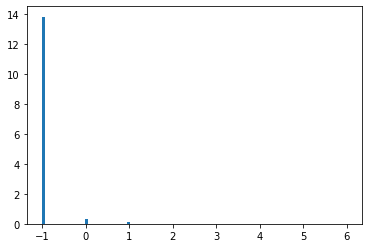

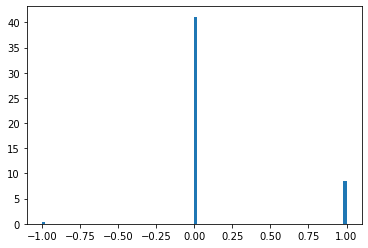

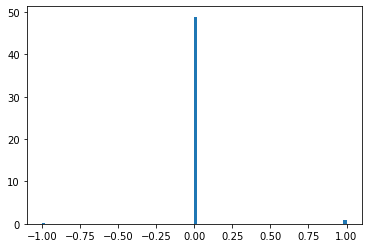

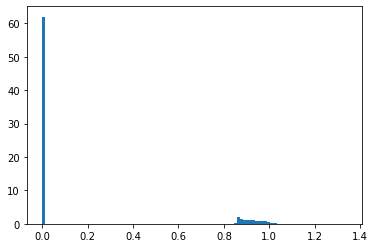

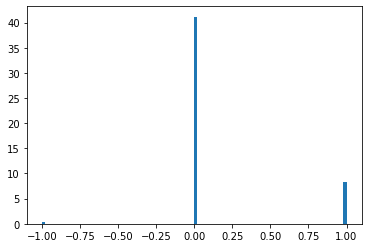

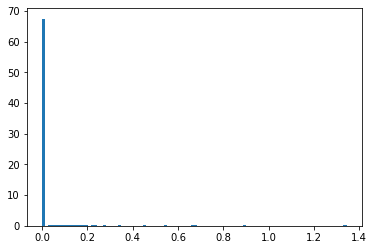

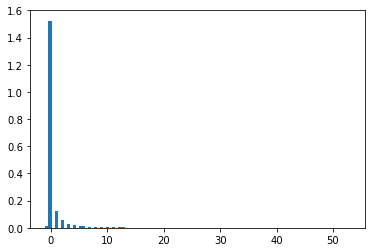

In [39]:
for c in most_full_cols.keys():
    plt.hist(train_data[c], bins=100, density=True)
    plt.show()


In [7]:
d = np.load(OUTDIR+"train_data_all.npy")
train_labels = np.load(OUTDIR+"train_labels_all.npy")

In [8]:
from torch.utils.data import Dataset, DataLoader
class CustomerData(Dataset):
    def __init__(self, data:np.array, test_mode=False, train_labels=None):
        self.data = data
        self.test_mode = test_mode
        self.train_labels = train_labels
        
    def __len__(self):
        return len(self.train_labels)

    def __getitem__(self, index):        
        feat =  torch.as_tensor(self.data[index], dtype=torch.float32)

        if self.test_mode:
            return feat, index
        else:
            customer_label = torch.as_tensor(self.train_labels[index], dtype=torch.float32)
            return feat, customer_label


In [75]:
train_dataset = CustomerData(d, train_labels=train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    

In [73]:
import torch.nn as nn
import torch.nn.functional as F

class Conv(nn.Module):

    def __init__(self, hidden_dim=64, output_dim=1, ):
        super(Conv, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.conv1 = nn.Conv1d(in_channels=13, out_channels=25, kernel_size=5, )
        self.conv2 = nn.Conv1d(in_channels=25, out_channels=5, kernel_size=5, )
        self.conv3 = nn.Conv1d(in_channels=5, out_channels=1, kernel_size=3, )
        self.fc1 = nn.Linear(in_features=154, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=1)
    def forward(self, h):
        h = F.selu(self.conv1(h))
        h = F.selu(self.conv2(h))
        h = F.selu(self.conv3(h))
        h = F.selu(self.fc1(h))
        return torch.sigmoid(self.fc2(h)).squeeze(-1)


In [70]:
class Att(nn.Module):

    def __init__(self, input_dim=160):
        super(Att, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=13, out_channels=10, kernel_size=5, )
        self.mha1 = nn.MultiheadAttention(embed_dim=input_dim, num_heads=4, batch_first=True)

        self.fc1 = nn.Linear(in_features=input_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)
    def forward(self, h):
        h = F.selu(self.conv1(h))
        h, attn_output_weights = self.mha1(query=h, key=h, value=h)
        h = F.selu(self.fc1(h))
        return torch.sigmoid(self.fc2(h).mean(dim=1))


In [79]:
model = Conv()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0)
criterion = torch.nn.BCELoss()

for epoch in range(15): 
    for feat, clabel in train_loader:
        pred = model(feat)
        weight = clabel.clone()
        weight[weight==0] = 3
        criterion.weight = weight
        loss = criterion(pred, clabel)
        
        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(epoch, loss.item(), amex_metric(clabel.detach().numpy(), pred.detach().numpy()))


pred = model(torch.as_tensor(d, dtype=torch.float32))
m =  amex_metric(train_labels, pred.detach().numpy())
print("performance", m)


0 2.6835310459136963 0.0038994302628517115
0 1.3037551641464233 0.12099688015538575
0 1.1099770069122314 0.11469155892109992
0 1.1101270914077759 0.12159242844873172
0 1.105299711227417 0.13680700906609594
0 1.1375690698623657 0.13134888050397492
0 1.1210076808929443 0.1306142624856902
0 1.0601576566696167 0.13498580903886903
0 1.0318727493286133 0.15497025490805236
0 0.9738003611564636 0.16824082057944867
0 0.9117414355278015 0.20195841346462068
0 0.8550071716308594 0.23155201192332092
0 0.8152492642402649 0.2606543156117253
0 0.7732800841331482 0.3016267001951969
0 0.7695967555046082 0.3505518256305712
0 0.7486988306045532 0.40047506126975896
0 0.7483823299407959 0.435248951855457
0 0.7365304827690125 0.46235520764274673
0 0.7256962656974792 0.49953669106689347
0 0.7137863039970398 0.5081474811076386
0 0.6868032813072205 0.5381696222029468
0 0.679303765296936 0.5284774400400502
0 0.6669118404388428 0.536185216425995
0 0.6552524566650391 0.5592239247266376
0 0.6509356498718262 0.54555

In [85]:
import json 
eval(model)

: 

: 